# II. MODEL TRAINING

In this section, we first started training models for binary classfication between wild type `Canton-S` and mutant types `Rutabaga, norpA7, and W1118`. We then trained the models for multi-label classification between each genotype. The machine learning algorithms we chose to experiment with were: `Logistic Regression, Support Vector Machine, Random Forest, and Gradient Boosting`.  

## Set Up

In [61]:
#Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

#helpers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics

from imblearn.over_sampling import SMOTE
import numpy as np
import os

# Model Selection

We used GridSearchCV to auto train each model with different hyper parameter options to select the best hyper parameters for each model.

In [2]:
def GridLogisticRegression():
    param_grid = param_grid = {
              'penalty': ['l1', 'l2'],  
              'random_state':[0, 42],
              'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
            'max_iter': [100, 200, 300,1000]
            }
    model = LogisticRegression()
    grid = GridSearchCV(model, param_grid, error_score = np.nan, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridSVC():
    param_grid = param_grid = {'C': [0.1, 1, 10, 100],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'gamma':['scale', 'auto'],
              'kernel': ['linear', 'rbf']}
    model = SVC()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridRandomForest():
    param_grid = param_grid = {  
              'criterion': ['gini', 'entropy'],
              'max_features': ['auto', 'sqrt', 'log2']}
    model = RandomForestClassifier()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

def GridGradientBoostingClassifier():
    param_grid = param_grid = {  
              'loss': ['deviance', 'exponential'],
              'n_estimators': [500, 1000],
                'max_depth':[3,5]
              }
    model = GradientBoostingClassifier()
    grid = GridSearchCV(model, param_grid, refit = True, verbose = 3, n_jobs=-1)
    return grid

# 1. Binary Classification

## Load data for training and testing

* Since our dataset has 5 partitions in total, we used variable `partition_index` to load the training partition that we want to use.
* We labeled `0` for the mutant types and `1` for the non-mutant type

In [62]:
DATA_PATH = "./Transform"
PARTITIONS = ["_first_2.5min.txt", "_first_5min.txt", "_last_5min.txt", "_last_2.5min.txt", "_10min.txt"]

In [97]:
labels = {0: ["W1118","norpA7","rutabaga"], 1: ["cantonS"]}
X0 = np.array(0)
y = np.array(0)

#change file index to load corresponding data 
partition_index = 1

#reading data accoding to label
for label in labels.keys():
    genotypes = labels[label]
    labelSize = 0
    for genotype in genotypes:
        fileName = genotype + PARTITIONS[partition_index]
        inFile = os.path.join(DATA_PATH, genotype, fileName)
        data = np.loadtxt(inFile)
        if X0.size == 1: # loading data the first time
            X0 = data
        else:
            X0 = np.concatenate((X0, data))
        labelSize += len(data)
        
    #create y value for corresponding label
    labelValues = np.zeros((1, labelSize)) + label
    if y.size == 1:
        y = labelValues
    else:
        y = np.concatenate((y, labelValues), axis = 1)

In [134]:
scaler = StandardScaler()
#Training data

scaled_data = scaler.fit_transform(X_shuffled)
X_train_processed = scaled_data


In [135]:
import pandas as pd

In [136]:
df = pd.DataFrame(X_train_processed)

In [137]:
def reCol(i):
    if i % 2 == 0:
        return "step"+str(i//2)
    else:
        return "turn"+str(i//2)

In [138]:
df = df.rename(reCol, axis='columns')

In [139]:
X_train_df = df[df.columns]

## Explainable Boosting

https://kdnuggets.com/2021/06/explainable-ai-xai-explainable-boosting-machines-ebm.html

In [140]:
from sklearn.model_selection import cross_val_score

In [141]:
data_length = X_train_df.shape[1]

In [142]:
feature_types = ["continuous" for _ in range(data_length)]
seed = 1

In [143]:
from interpret.glassbox import ExplainableBoostingClassifier

ebm = ExplainableBoostingClassifier(feature_types=feature_types, random_state=seed)
#ebm.fit(X_train_df, y_train.ravel())
scores = cross_val_score(ebm, X_train_df, y.T,cv=5)
# or substitute with LogisticRegression, DecisionTreeClassifier, RuleListClassifier, ...
# EBM supports pandas dataframes, numpy arrays, and handles "string" data natively.


In [144]:
scores

array([0.47413793, 0.59130435, 0.50434783, 0.47826087, 0.51304348])

In [131]:
print("%0.2f accuracy with a standard deviation of %0.2f"%(scores.mean(),scores.std()))

0.50 accuracy with a standard deviation of 0.03


In [139]:
from interpret import set_visualize_provider
from interpret.provider import InlineProvider
set_visualize_provider(InlineProvider())

In [166]:
from interpret import show
ebm_global = ebm.explain_global()
#show(ebm_global)

#ebm_local = ebm.explain_local(X_test[:5], y_test[:5])
#show(ebm_local)

In [18]:
from interpret.perf import ROC
ebm_perf = ROC(ebm.predict_proba).explain_perf(X_test_processed, y_test, name='EBM')
show(ebm_perf)

In [59]:
import pickle
def loadFeatureScore(file):
    data = None
    with open(file,"rb") as pickle_file:
        data = pickle.load(pickle_file)
    return data
files = ["ebm_first2_5min.json",
         "ebm_first5_0min.json",
         "ebm_last5_0min.json",
         "ebm_last2_5min.json",
         "ebm_10min.json"]
ebm = loadFeatureScore(files[4])

In [60]:
predictions = ebm.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85        72
         1.0       0.73      0.84      0.78        44

    accuracy                           0.82       116
   macro avg       0.81      0.82      0.81       116
weighted avg       0.83      0.82      0.82       116



In [168]:
ebm_data = ebm_global.data()
names = ebm_data['names']
scores = ebm_data['scores']


In [169]:
len(names)

310

In [146]:
import matplotlib.pyplot as plt

In [144]:
def shorten(s,i):
    return s[0]+str(i)

In [170]:
steps = [shorten(names[i],i//2) for i in range(data_length) if i % 2 ==0]
step_scores = [scores[i] for i in range(data_length) if i % 2 ==0]

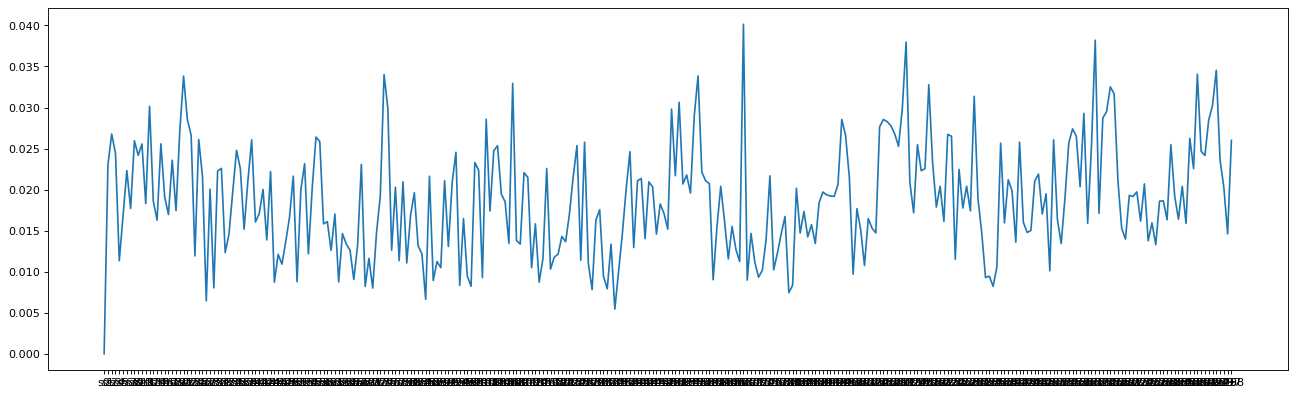

In [119]:
plt.figure(figsize=(20,6),dpi=80)
plt.plot(steps[:-1],step_scores[:-1])

In [171]:
turns = [shorten(names[i],i//2) for i in range(data_length) if i % 2 !=0]
turn_scores = [scores[i] for i in range(data_length) if i % 2 !=0]


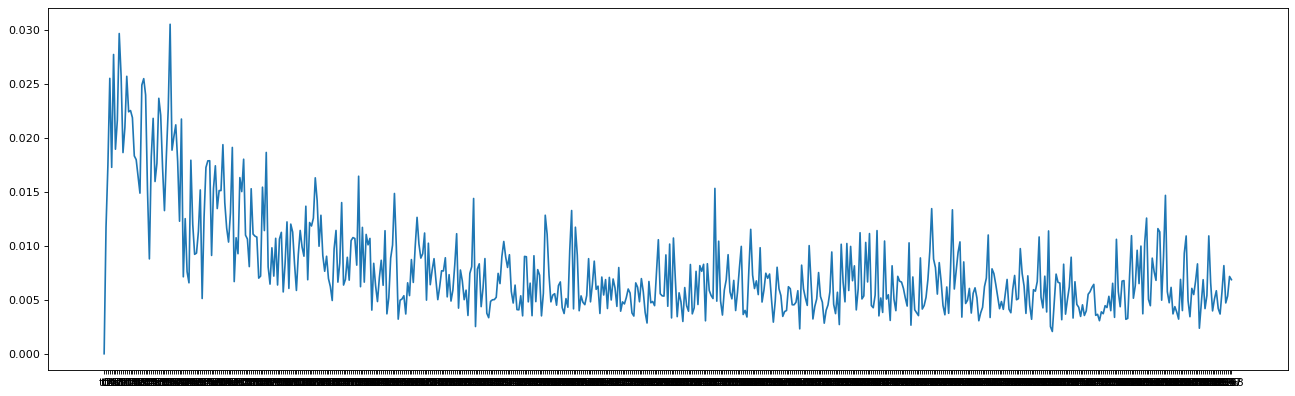

In [27]:
plt.figure(figsize=(20,6),dpi=80)
plt.plot(turns[:-1],turn_scores[:-1])

### Save model

In [172]:
import pickle

In [173]:
def saveData(data,file):
    with open(file,"wb") as pickle_file:
        pickle.dump(data,pickle_file)

In [174]:
model_file = "ebm_last2_5min.json"
saveData(ebm,model_file)

In [175]:
scores = {}
scores["steps"] = [steps,step_scores]
scores["turns"] = [turns,turn_scores]

In [176]:
score_file = "ebm_scores_last2_5min.json"
saveData(scores,score_file)

## a. Training with Logistic Regression

### Training

In [19]:
grid = GridLogisticRegression()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 64 candidates, totalling 320 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.75869565        nan        nan
        nan 0.75434783 0.75869565 0.75869565 0.76086957 0.75869565
 0.75869565 0.75869565 0.75869565 0.75652174        nan        nan
        nan 0.76304348        nan        nan        nan 0.75869565
 0.75869565 0.75869565 0.76086957 0.75869565 0.75869565 0.75869565
 0.76304348 0.75869565        nan        nan        nan 0.75869565
        nan        nan        nan 0.75869565 0.75869565 0.75869565
 0.76304348 0.76086957 0.75869565 0.75869565 0.76086957 0.76086957
        nan        nan        nan 0.76956522        nan        nan
        nan 0.76956522 0.75869565 0.75869565 0.76086957 0.75869565
 0.75869565 0.75869565 0.75869565 0.75869565]
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached wh

GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300, 1000],
                         'penalty': ['l1', 'l2'], 'random_state': [0, 42],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             verbose=3)

### Testing

In [20]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.78      0.68      0.73        72
         1.0       0.57      0.68      0.62        44

    accuracy                           0.68       116
   macro avg       0.67      0.68      0.67       116
weighted avg       0.70      0.68      0.69       116



### Get the hyper parameters

In [101]:
grid.best_params_

{'max_iter': 1000, 'penalty': 'l1', 'random_state': 0, 'solver': 'saga'}

## b. Training with Random Forest

### Training

In [102]:
grid = GridRandomForest()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

### Testing

In [103]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82        72
         1.0       0.69      0.80      0.74        44

    accuracy                           0.78       116
   macro avg       0.77      0.79      0.78       116
weighted avg       0.80      0.78      0.79       116



### Get the hyper parameters

In [104]:
grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto'}

## c. Training with Support Vector Machine

### Training

In [105]:
grid = GridSVC()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

### Testing

In [106]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82        72
         1.0       0.70      0.75      0.73        44

    accuracy                           0.78       116
   macro avg       0.77      0.78      0.77       116
weighted avg       0.79      0.78      0.79       116



### Get the hyper parameters

In [107]:
grid.best_params_

{'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}

## d. Training with Gradient Boosting

### Training

In [108]:
grid = GridGradientBoostingClassifier()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['deviance', 'exponential'],
                         'max_depth': [3, 5], 'n_estimators': [500, 1000]},
             verbose=3)

### Testing

In [109]:
predictions = grid.predict(X_test_processed)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.86      0.78      0.82        72
         1.0       0.69      0.80      0.74        44

    accuracy                           0.78       116
   macro avg       0.77      0.79      0.78       116
weighted avg       0.80      0.78      0.79       116



### Get the hyper parameters

In [110]:
grid.best_params_

{'loss': 'exponential', 'max_depth': 3, 'n_estimators': 500}

# 2. Multi-label Classification

## Load data for training and testing

* Since our dataset has 5 partitions in total, we used variable `partition_index` to load the training partition that we want to use.
* We labeled `0`: cantonS, `1`: W118, `2`: norpA7, `3`: rutabaga.
* Since the data between each class was not balanced, we used SMOTE to perform over sampling for low data classes.
* We used confusion matrix to measure the performance of each trained model.

In [95]:
DATA_PATH = "./Transform"
PARTITIONS = ["_first_2.5min.txt", "_first_5min.txt", "_last_5min.txt", "_last2.5min.txt", "_10min.txt"]

In [96]:
labels = {0: ["cantonS"], 1: ["W1118"],2:["norpA7"],3:["rutabaga"]}
X0 = np.array(0)
y = np.array(0)

#change file index to load corresponding data 
partition_index = 0

#reading data accoding to label
for label in labels.keys():
    genotypes = labels[label]
    labelSize = 0
    for genotype in genotypes:
        fileName = genotype + PARTITIONS[partition_index]
        inFile = os.path.join(DATA_PATH, genotype, fileName)
        data = np.loadtxt(inFile)
        if X0.size == 1: # loading data the first time
            X0 = data
        else:
            X0 = np.concatenate((X0, data))
        labelSize += len(data)
        
    #create y value for corresponding label
    labelValues = np.zeros((1, labelSize)) + label
    if y.size == 1:
        y = labelValues
    else:
        y = np.concatenate((y, labelValues), axis = 1)

* We then split the dataset into training and testing with ration 80:20

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X0, y.T, test_size = 0.20, random_state=101)

* We then perform SMOTE in the train dataset to balance it

In [98]:
#Balance the training set
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

* We then used StandarScaler to normalize both training and testing data

In [99]:
scaler = StandardScaler()
#Training data

scaled_data = scaler.fit_transform(X_train)
X_train_processed = scaled_data

#Testing data
scaled_data = scaler.transform(X_test)
X_test_processed = scaled_data

## Prepare metric method

In [100]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [101]:
def measurePerformanceWithConfusionMatrix(model, X_test, y_test, labels):
    titles_options = [("Confusion matrix, without normalization", None),
                      ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=labels,
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)
    plt.show()

## a. Training with Logistic Regression

### Training

In [102]:
grid = GridLogisticRegression()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 48 candidates, totalling 240 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan 0.80222598        nan        nan
        nan 0.80222598 0.81170752 0.81170752 0.79867568 0.79512539
 0.81170752 0.81170752 0.79630882 0.79630882        nan        nan
        nan 0.80222598        nan        nan        nan 0.80222598
 0.81170752 0.81170752 0.80222598 0.79749225 0.81170752 0.81170752
 0.80222598 0.79749225        nan        nan        nan 0.80340237
        nan        nan        nan 0.80340237 0.81170752 0.81170752
 0.80341646 0.80104255 0.81170752 0.81170752 0.80341646 0.80104255]
  warnings.warn(


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'max_iter': [100, 200, 300], 'penalty': ['l1', 'l2'],
                         'random_state': [0, 42],
                         'solver': ['newton-cg', 'lbfgs', 'sag', 'saga']},
             verbose=3)

### Testing

In [103]:
labels =["cantonS", "W1118", "norpA7", "rutabaga"]

Confusion matrix, without normalization
[[40  7 11  6]
 [11  8  2  4]
 [ 6  3  7  2]
 [ 6  1  0  2]]
Normalized confusion matrix
[[0.625      0.109375   0.171875   0.09375   ]
 [0.44       0.32       0.08       0.16      ]
 [0.33333333 0.16666667 0.38888889 0.11111111]
 [0.66666667 0.11111111 0.         0.22222222]]


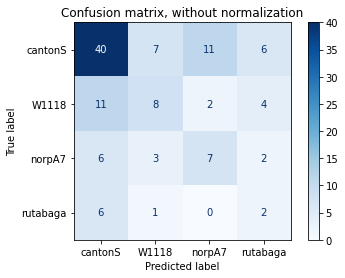

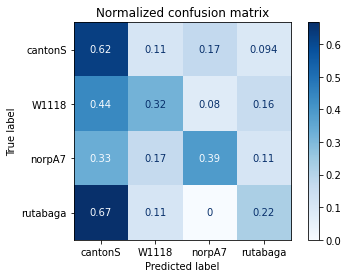

In [104]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [105]:
grid.best_params_

{'max_iter': 100, 'penalty': 'l2', 'random_state': 0, 'solver': 'newton-cg'}

## b. Training with Random Forest

### Training

In [106]:
grid = GridRandomForest()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[48  8  4  4]
 [ 5 12  7  1]
 [ 6  1 10  1]
 [ 6  0  0  3]]
Normalized confusion matrix
[[0.75       0.125      0.0625     0.0625    ]
 [0.2        0.48       0.28       0.04      ]
 [0.33333333 0.05555556 0.55555556 0.05555556]
 [0.66666667 0.         0.         0.33333333]]


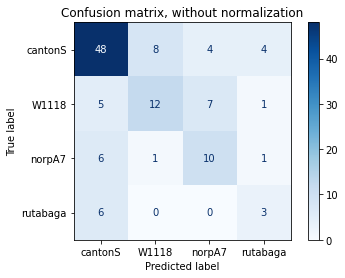

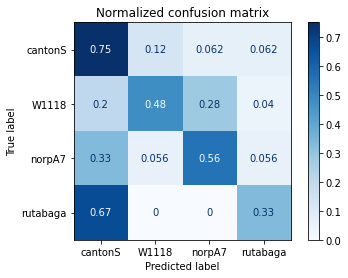

In [107]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [108]:
grid.best_params_

{'criterion': 'entropy', 'max_features': 'auto'}

## c. Training with Support Vector Machine

### Training

In [109]:
grid = GridSVC()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[56  4  4  0]
 [10  7  8  0]
 [ 9  1  8  0]
 [ 6  1  1  1]]
Normalized confusion matrix
[[0.875      0.0625     0.0625     0.        ]
 [0.4        0.28       0.32       0.        ]
 [0.5        0.05555556 0.44444444 0.        ]
 [0.66666667 0.11111111 0.11111111 0.11111111]]


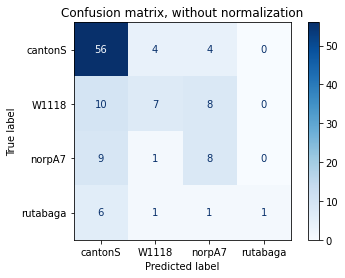

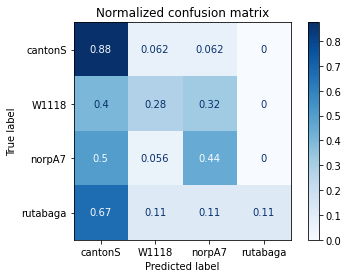

In [110]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [111]:
grid.best_params_

{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}

## d. Training with Gradient Boosting

### Training

In [112]:
grid = GridGradientBoostingClassifier()
grid.fit(X_train_processed, y_train.ravel())

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.86262327 0.86381375        nan        nan]
  warnings.warn(


GridSearchCV(estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'loss': ['deviance', 'exponential'],
                         'n_estimators': [500, 1000]},
             verbose=3)

### Testing

Confusion matrix, without normalization
[[54  4  4  2]
 [ 7  9  8  1]
 [ 6  1 10  1]
 [ 4  0  0  5]]
Normalized confusion matrix
[[0.84375    0.0625     0.0625     0.03125   ]
 [0.28       0.36       0.32       0.04      ]
 [0.33333333 0.05555556 0.55555556 0.05555556]
 [0.44444444 0.         0.         0.55555556]]


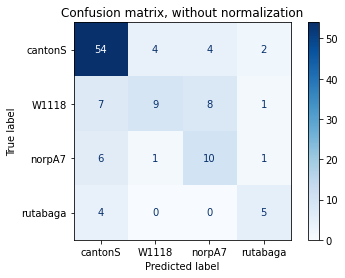

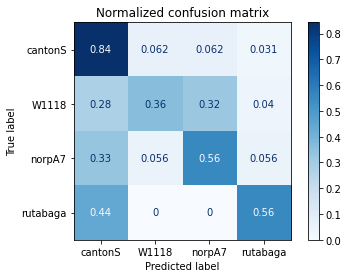

In [113]:
measurePerformanceWithConfusionMatrix(grid, X_test_processed, y_test, labels)

### Get the hyper parameters

In [114]:
grid.best_params_

{'loss': 'deviance', 'n_estimators': 1000}